In [1]:
import glob
import imageio
import os
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

from models.rendering import *
from models.nerf import *

import metrics

from datasets import dataset_dict, flowlib, ray_utils

torch.backends.cudnn.benchmark = True
np.set_printoptions(suppress=True)

img_wh = (512, 288)
root_dir = '/home/ubuntu/data/nerf_example_data/my/kid-running/dense/'

dataset = dataset_dict['monocular'](root_dir, 'test', img_wh=img_wh, start_end=(0, 30))

In [2]:
@torch.no_grad()
def f(rays, ts, **kwargs):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        kwargs_ = {}
        for k, v in kwargs.items():
            if k in ['t_embedded', 'a_embedded']: kwargs_[k] = v[i:i+chunk]
            else: kwargs_[k] = v
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        ts[i:i+chunk],
                        dataset.N_frames-1,
                        N_samples,
                        0,
                        0,
                        N_importance,
                        chunk,
                        test_time=True,
                        **kwargs_)

        for k, v in rendered_ray_chunks.items(): results[k] += [v.cpu()]
    for k, v in results.items(): results[k] = torch.cat(v, 0)
    return results

In [3]:
ckpt_path = 'ckpts/kid/epoch=49.ckpt'


N_vocab = 100
N_tau = 48
N_samples = 128
N_importance = 0
chunk = 1024*16

embedding_xyz = PosEmbedding(9, 10)
embedding_dir = PosEmbedding(3, 4)
embeddings = {'xyz': embedding_xyz, 'dir': embedding_dir}
embedding_t = torch.nn.Embedding(N_vocab, N_tau).cuda()
load_ckpt(embedding_t, ckpt_path, model_name='embedding_t')
embeddings['t'] = embedding_t


nerf_fine = NeRF('fine',
                 in_channels_xyz=6*10+3,
                 encode_transient=True,
                 in_channels_t=N_tau,
                 output_flow=True,
                 flow_scale=0.2).cuda()
load_ckpt(nerf_fine, ckpt_path, 'nerf_fine')
models = {'fine': nerf_fine}

if N_importance > 0:
    nerf_coarse = NeRF('coarse',
                       in_channels_xyz=6*10+3,
                       encode_transient=encode_transient,
                       in_channels_t=N_tau).cuda()
    load_ckpt(nerf_coarse, ckpt_path, 'nerf_coarse')
    models['coarse'] = nerf_coarse

In [4]:
# from scipy.spatial.transform.rotation import Rotation
# dataset.poses_test[8, 1, 3] += 0.1
# dataset.poses_test[20,:3,:3] = dataset.poses_test[0,:3,:3]@Rotation.from_euler('x', -3, degrees=True).as_matrix()

sample = dataset[8] # select pose
rays = sample['rays']
ts = sample['ts']*0+4 # select time
output_transient = True
output_transient_flow = []
if dataset.flow_fw_paths: output_transient_flow += ['fw']
if dataset.flow_bw_paths: output_transient_flow += ['bw']
kwargs = {'output_transient': output_transient,
          'output_transient_flow': output_transient_flow,}
#           'dataset': dataset}

t = time.time()
results = f(rays.cuda(), ts.cuda(), **kwargs)
torch.cuda.synchronize()
print(time.time()-t)

7.883044004440308


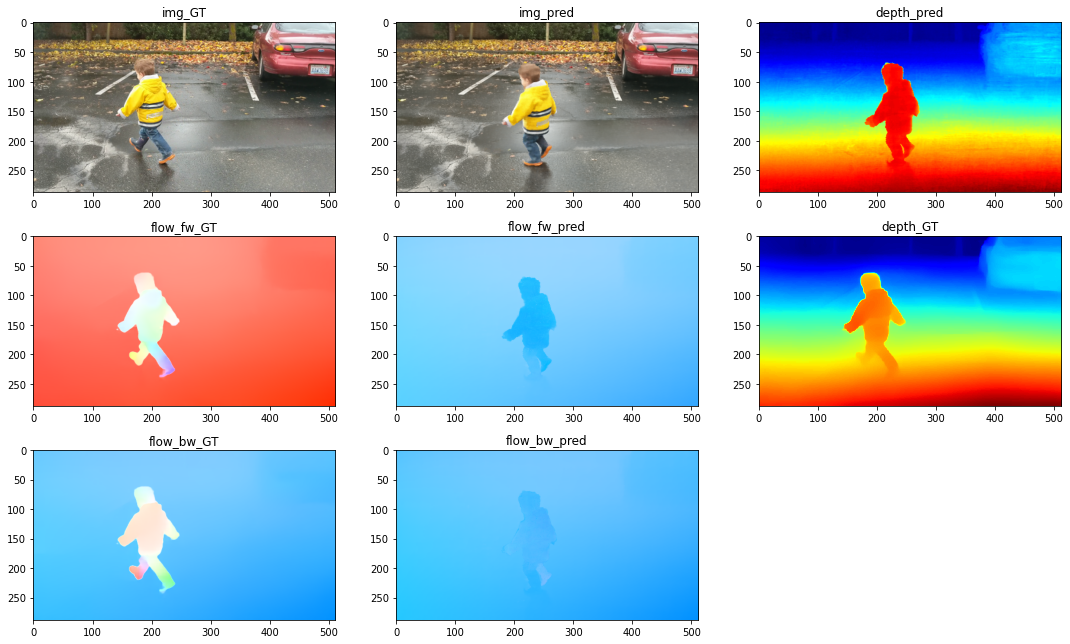

PSNR between GT and pred: 19.678499221801758
SSIM between GT and pred in mask: 0.9234390258789062 

PSNR between GT and pred in mask: 10.376827239990234
SSIM between GT and pred in mask: 0.5653729438781738 



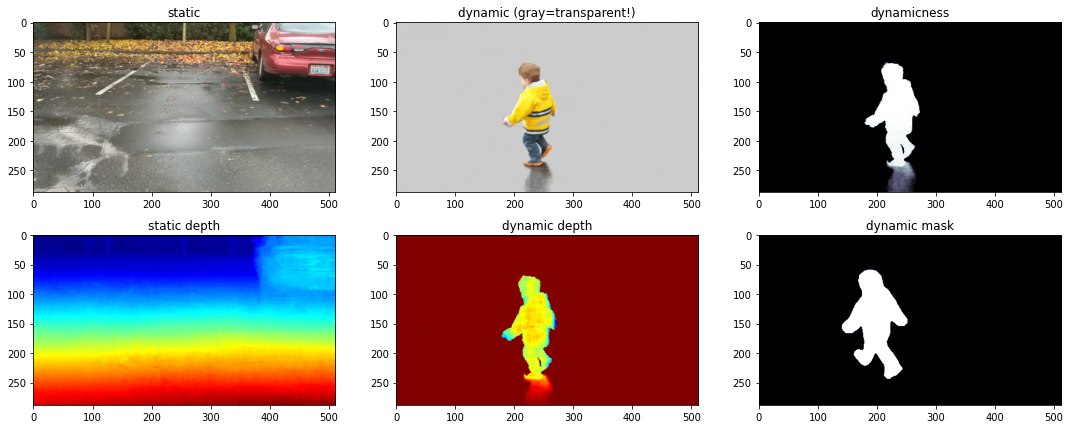

PSNR between GT and static: 21.739099502563477 



In [5]:
from kornia import create_meshgrid

try: img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
except: pass
img_pred = np.clip(results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy(), 0, 1)
try:
    grid = create_meshgrid(img_wh[1], img_wh[0], normalized_coordinates=False)[0]
    if 'fw' in kwargs['output_transient_flow']:
        xyz_fw_w = ray_utils.ndc2world(results['transient_xyz_fw'].cpu(), dataset.Ks[sample['cam_ids']]).unsqueeze(-1)
        ts_fw = torch.clamp(ts+1, max=dataset.N_frames-1)
        Ps_fw = dataset.Ps[sample['cam_ids'], ts_fw] # (N_rays, 3, 4)
        uvd_fw = Ps_fw[:, :3, :3] @ xyz_fw_w + Ps_fw[:, :3, 3:]
        uv_fw = uvd_fw[:, :2, 0] / uvd_fw[:, 2:, 0] # (N_rays, 2)
        uv_fw = uv_fw.view(img_wh[1], img_wh[0], 2) - grid
    if 'bw' in kwargs['output_transient_flow']:
        xyz_bw_w = ray_utils.ndc2world(results['transient_xyz_bw'].cpu(), dataset.Ks[sample['cam_ids']]).unsqueeze(-1)
        ts_bw = torch.clamp(ts-1, min=0)
        Ps_bw = dataset.Ps[sample['cam_ids'], ts_bw] # (N_rays, 3, 4)
        uvd_bw = Ps_bw[:, :3, :3] @ xyz_bw_w + Ps_bw[:, :3, 3:]
        uv_bw = uvd_bw[:, :2, 0] / uvd_bw[:, 2:, 0] # (N_rays, 2)
        uv_bw = uv_bw.view(img_wh[1], img_wh[0], 2) - grid
except: pass
img_pred_ = Image.fromarray((img_pred*255).astype(np.uint8))
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])
depth_pred_ = visualize_depth(depth_pred).permute(1,2,0).numpy()

plt.subplots(figsize=(15, 9))
plt.tight_layout()
plt.subplot(331)
plt.title('img_GT')
try: plt.imshow(img_gt)
except: pass
plt.subplot(332)
plt.title('img_pred')
plt.imshow(img_pred_)
plt.subplot(333)
plt.title('depth_pred')
plt.imshow(depth_pred_)
try:
    plt.subplot(334)
    plt.title('flow_fw_GT')
    plt.imshow(flowlib.flow_to_image(sample['flow_fw']))
except: pass
try:
    plt.subplot(335)
    plt.title('flow_fw_pred')
    plt.imshow(flowlib.flow_to_image(uv_fw.numpy()))
except: pass
if dataset.disp_paths:
    plt.subplot(336)
    plt.title('depth_GT')
    plt.imshow(sample['disp'].reshape(img_wh[1], img_wh[0]), 'jet')
try:
    plt.subplot(337)
    plt.title('flow_bw_GT')
    plt.imshow(flowlib.flow_to_image(sample['flow_bw']))
except: pass
try:
    plt.subplot(338)
    plt.title('flow_bw_pred')
    plt.imshow(flowlib.flow_to_image(uv_bw.numpy()))
except: pass
plt.show()

try:
    print('PSNR between GT and pred:', metrics.psnr(img_gt, img_pred).item())
    print('SSIM between GT and pred in mask:', metrics.ssim(img_gt, torch.from_numpy(img_pred)).item(), '\n')
except: pass
if dataset.mask_paths:
    mask = sample['mask'].view(img_wh[1], img_wh[0])
    if (mask==1).any():
        try:
            print('PSNR between GT and pred in mask:', metrics.psnr(img_gt, img_pred, mask==0).item())
            print('SSIM between GT and pred in mask:', metrics.ssim(img_gt, torch.from_numpy(img_pred), mask==0).item(), '\n')
        except: pass

if output_transient:
    img_pred_static = np.clip(results['_static_rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy(), 0, 1)
    img_pred_transient = np.clip(results['transient_rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy(), 0, 1)
    depth_pred_static = results['_static_depth_fine'].view(img_wh[1], img_wh[0]).cpu()
    depth_pred_transient = results['transient_depth_fine'].view(img_wh[1], img_wh[0]).cpu()
    dynamicness = results['transient_alpha_fine'].view(img_wh[1], img_wh[0]).cpu()
    plt.subplots(figsize=(15, 6))
    plt.tight_layout()
    plt.subplot(231)
    plt.title('static')
    plt.imshow(img_pred_static)
    plt.subplot(232)
    plt.title('dynamic (gray=transparent!)')
    plt.imshow(img_pred_transient)
    plt.subplot(233)
    plt.title('dynamicness')
    plt.imshow(dynamicness, 'bone')
    plt.subplot(234)
    plt.title('static depth')
    plt.imshow(visualize_depth(depth_pred_static).permute(1,2,0))
    plt.subplot(235)
    plt.title('dynamic depth')
    plt.imshow(visualize_depth(depth_pred_transient).permute(1,2,0))
    plt.subplot(236)
    plt.title('dynamic mask')
    plt.imshow(mask==0, 'bone')
    plt.show()
    try: print('PSNR between GT and static:', metrics.psnr(img_gt, img_pred_static).item(), '\n')
    except: pass

In [6]:
scene_name = 'kid-fix-time-change-view'
os.makedirs(f'results/{scene_name}', exist_ok=True)

last_results = None
for i in tqdm(range(0, len(dataset), 1)):
    sample = dataset[i]
    rays = sample['rays'].cuda()
    ts = sample['ts'].cuda()*0+8
    kwargs = {'output_transient': True, 'output_transient_flow': ['fw', 'bw'], 'dataset': dataset}
    results = f(rays, ts, **kwargs) if last_results is None else last_results
#     results_tp1 = f(rays, ts+1, **kwargs)
    for dt in [0, 0.25, 0.5, 0.75][:1]:
        out = np.zeros((img_wh[1]*2, img_wh[0], 3), np.uint8)
        if dt == 0:
            img_pred = np.clip(results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy(), 0, 1)
            depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])
            depth_pred = visualize_depth(depth_pred).permute(1,2,0).numpy()
            out[img_wh[1]:] = (255*depth_pred).astype(np.uint8)
        else:
            img_pred = np.clip(interpolate(results, results_tp1, dt, dataset.Ks[sample['cam_ids']], sample['c2w'], img_wh).cpu().numpy(), 0, 1)
        img_pred = (255*img_pred).astype(np.uint8)
#         cv2.putText(img_pred, f'{i+dt:.2f}', (20, 250), cv2.FONT_HERSHEY_SIMPLEX , 1, (0, 255, 0), 2)
        out[:img_wh[1]] = img_pred
        imageio.imwrite(f'results/{scene_name}/{i:03d}_{int(dt*100):03d}.png', out)
#     last_results = results_tp1
# # add last frame
# out = np.zeros((2*img_wh[1], img_wh[0], 3), np.uint8)
# img_pred = np.clip(results_tp1['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy(), 0, 1)
# cv2.putText(img_pred, f'{i+1:.2f}', (20, 250), cv2.FONT_HERSHEY_SIMPLEX , 1, (0, 255, 0), 2)
# out[:img_wh[1]] = img_pred
# depth_pred = results_tp1['depth_fine'].view(img_wh[1], img_wh[0])
# depth_pred = visualize_depth(depth_pred).permute(1,2,0).numpy()
# out[img_wh[1]:] = (255*depth_pred).astype(np.uint8)
# imgs += [out]

  0%|          | 0/30 [00:00<?, ?it/s]

In [4]:
import glob
import imageio
import numpy as np
img_ps1 = sorted(glob.glob('/home/ubuntu/workspace/Neural-Scene-Flow-Fields/nsff_exp/logs/kid-running_ndc_5f_sv_of_sm_unify3_F00-30/render-spiral-frame-000_path_360001/images/*.png'))
img_ps2 = sorted(glob.glob('results/monocular/kid_reconstruction_bg/*.png'))
imgs = []
for i, (img_p1, img_p2) in enumerate(zip(img_ps1[:], img_ps2[:])):
    imgs += [np.concatenate([imageio.imread(img_p2)[:288],
                             np.ones((288, 10, 3), np.uint8)*255,
                             imageio.imread(img_p1)], 1)]
    
imageio.mimsave('bg_recon.gif', imgs, fps=5)